# Final Project Shariq Mian

# Introduction
In many industries, organizations generate a vast amount of textual data through customer feedback, social media interactions, surveys, and other sources. Extracting meaningful insights and understanding the underlying relationships within this textual data is crucial for businesses to make informed decisions, improve customer satisfaction, and gain a competitive edge. I want to create a corpus of Predicates which will allow is to get the subject and the object of the sentence. This allows for each classification or trend analysis of your data.




### Approach:
To tackle this problem, I am employing various natural language processing (NLP) techniques and data preprocessing methods. It leverages libraries such as spaCy, and NLTK to perform tasks such as entity extraction, predicate identification, sentiment analysis, and data cleaning. I will also utilizes graph visualization techniques using NetworkX to represent the relationships between entities visually.
By following this approach, businesses can gain the following benefits:


### Entity and Predicates Extraction:
I hope to identifies key entities, such as people, organizations, locations, and products, from the text. This helps businesses understand who or what is being discussed and can aid in tasks such as customer segmentation or identifying popular trends.
By extracting predicates or action words from the text, it should reveals the relationships between entities. This allows businesses to uncover patterns and connections between different entities, enabling them to understand the context and extract meaningful insights.

### Graph Visualization:
The code visualizes the relationships between entities using a graph representation. This visual depiction provides a clear and intuitive understanding of the connections and dependencies between different entities, helping businesses identify central nodes, clusters, or important influencers.

In [2]:
import numpy as np #
import pandas as pd
import os
import warnings
import re
import string
warnings.filterwarnings("ignore")
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop= stopwords.words('english')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemm= WordNetLemmatizer()
from textblob import TextBlob
import bs4
import requests
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
%%time
#using pandas to read the train and test file
train= pd.read_csv('https://github.com/mianshariq/Datasets/raw/c24b8145be80076770392b68af9b8f1e66877439/train%5B1%5D.csv', encoding="ISO-8859-1")
test=pd.read_csv('https://github.com/mianshariq/Datasets/raw/c24b8145be80076770392b68af9b8f1e66877439/test%5B1%5D.csv', encoding="ISO-8859-1")
df= pd.concat([train,test])
print("Train data frame shape:",train.shape)
print("Test data frame shape:",test.shape)
print("Complete data frame shape:",df.shape)

Train data frame shape: (31962, 3)
Test data frame shape: (17197, 2)
Complete data frame shape: (49159, 3)
CPU times: user 159 ms, sys: 35.2 ms, total: 195 ms
Wall time: 4.09 s


In [4]:
df.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


In [5]:
train["label"].value_counts() #we have an imbalance class problem

0    29720
1     2242
Name: label, dtype: int64

# Text Cleaning

The first step of text analytics is to clean text from noises.  

### Lower Casing
 To maintain uniformity, it always advisable to convert the text into lower case.

In [6]:
df['tweet']= df["tweet"].str.lower()
df.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


## Removal of HTML Noise/characters

In [7]:
df['tweet']=df['tweet'].str.replace("<[^<]+?>","",regex=True)
df.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


## Contractions

Because of limited characters of tweet,people often use contracted form of word so they can fit more characters. I found a a dictionary of such words.

In [8]:
contractions = {
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"i'd": "i had / i would",
"i'd've": "i would have",
"i'll": "i shall / I will",
"i'll've": "i shall have / i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

cont_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return cont_re.sub(replace, s)
df['tweet'] =df['tweet'].apply(expand)
df.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i cannot u...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


## Removal of URLs, Hashtag, Mentions-

Remove URL, punctuations, Hashes, Mentions

In [9]:
#Remove http and url
df['tweet']=df['tweet'].str.replace('https?://\S+|www\.\S+', '',regex=True)
#Remove punctuations and
df['tweet']=df['tweet'].str.replace('[%s]' % re.escape(string.punctuation), '', regex=True)
#lets remove new line characters if any
df['tweet']=df['tweet'].str.replace('\n', '', regex=True)
df.head()

,id,label,tweet
0,1,0.0,user when a father is dysfunctional and is so...
1,2,0.0,user user thanks for lyft credit i cannot use ...
2,3,0.0,bihday your majesty
3,4,0.0,model i love u take with u all the time in u...
4,5,0.0,factsguide society now motivation


##  Remove Emojis

Emojis are common in tweets or any social media data. We can remove them or analyze separately.

In [10]:
#for this analysis, I am removing the emojis
def emojis(text):
    emoji = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji.sub(r'', text)

df['tweet']=df['tweet'].apply(lambda x: emojis(x))
df.head()

,id,label,tweet
0,1,0.0,user when a father is dysfunctional and is so...
1,2,0.0,user user thanks for lyft credit i cannot use ...
2,3,0.0,bihday your majesty
3,4,0.0,model i love u take with u all the time in u...
4,5,0.0,factsguide society now motivation


## Stopwords Removal

Stopwords are common and frequently used words. They add little value and increase dimensionality of the data

In [11]:
df['tweet'].apply(lambda x: [item for item in x if item not in stop])
df.head()

,id,label,tweet
0,1,0.0,user when a father is dysfunctional and is so...
1,2,0.0,user user thanks for lyft credit i cannot use ...
2,3,0.0,bihday your majesty
3,4,0.0,model i love u take with u all the time in u...
4,5,0.0,factsguide society now motivation


## Normalization (Lemmatization)

Inflectional form of word such better, best for good are often found in text data. They increases the dimensionality of data and little value

In [12]:
def lemmatization(df):
    df['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df.head()

,id,label,tweet
0,1,0.0,user when a father is dysfunctional and is so...
1,2,0.0,user user thanks for lyft credit i cannot use ...
2,3,0.0,bihday your majesty
3,4,0.0,model i love u take with u all the time in u...
4,5,0.0,factsguide society now motivation


## Additional Repetitive word

We know from the problem statement that names have been replaced by word "user". Therefore it will right exclude them as well

In [13]:
df['tweet']=df['tweet'].str.replace('user', '',regex=True)
df.head()

,id,label,tweet
0,1,0.0,when a father is dysfunctional and is so sel...
1,2,0.0,thanks for lyft credit i cannot use cause th...
2,3,0.0,bihday your majesty
3,4,0.0,model i love u take with u all the time in u...
4,5,0.0,factsguide society now motivation


In [14]:
#Restricting graph to 5000 tweets only
tweets=df['tweet'][:5000]

# Entities Function

A sentence consist of subject, predicate and object. Below we are going to extract subject and object from sentences.

In [15]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text


  return [ent1.strip(), ent2.strip()]

## Entity Pairs

In [16]:
entity_pairs = []

for i in tqdm(tweets):
  entity_pairs.append(get_entities(i))

entity_pairs[10:20]

100%|██████████| 5000/5000 [00:51<00:00, 97.07it/s] 


[['price index mom', 'silver gold forex'],
 ['we', 'orlandoshooting orlando values'],
 ['today 80days', 'daddy'],
 ['cnn', 'wall chant tcot'],
 ['comment', 'opkillingbay seashepherd helpcovedolphins'],
 ['ouchjunior', ''],
 ['i', 'thankful  positive'],
 ['you', ''],
 ['smiles', 'around ig people'],
 ['essential  oils', 'chemicals']]

# Predicates_Extraction
Extracting predicates as well

In [17]:
def predicates(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)

    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)

    return [doc[start:end].text for _, start, end in matches]

predicates_list = [predicates(i) for i in tqdm(tweets)]


100%|██████████| 5000/5000 [01:05<00:00, 76.45it/s]


In [18]:
predicates_list

[['is', 'is dysfunctional'],
 ['use'],
 ['bihday'],
 ['love', 'â\x9fâ\x91â\x84ã'],
 ['motivation'],
 ['allshowandnogo'],
 ['camping'],
 ['think', 'think about'],
 ['won'],
 ['has'],
 ['climbed', 'climbed from', 'climbed from previous'],
 ['are'],
 ['gettingfed'],
 ['calls'],
 ['thecove'],
 ['is'],
 ['am', 'am thankful'],
 ['retweet'],
 ['make'],
 ['made', 'made of'],
 ['was'],
 ['pissed', 'pissed funny'],
 ['has'],
 ['says'],
 ['tgif'],
 ['sign', 'sign by'],
 ['smiles'],
 ['had'],
 ['â\x9fâ\x92â\x93'],
 ['went', 'went to'],
 ['had'],
 ['exist'],
 ['rip', 'rip to'],
 ['was'],
 ['has'],
 ['dominate'],
 ['ripinkylife'],
 ['tells'],
 ['waited'],
 ['am', 'am thankful'],
 ['finish'],
 ['is', 'is hard'],
 ['is'],
 ['shares', 'â\x9fâ\x8fâ¼'],
 ['grow'],
 ['am', 'am amazing'],
 ['love', 'â\x9fâ\x91â\x84ã'],
 ['m'],
 ['feeling', 'feeling blue'],
 ['knowing'],
 ['remove'],
 ['got'],
 ['off'],
 ['let'],
 ['thank'],
 ['scourge', 'scourge on'],
 ['lets'],
 ['videos'],
 ['times', 'times with'],
 ['se

## Top 20 Predicates

In [183]:
pd.Series(predicates_list).value_counts()[:20]

[is]                 272
[has]                115
[are]                 78
[am, am thankful]     67
[be]                  65
[have]                62
[love]                59
[am]                  56
[love, âââã]       50
[got]                 46
[was]                 34
[had]                 32
[make]                31
[thank]               30
[think]               28
[want]                28
[wait]                28
[get]                 28
[need]                25
[see]                 24
dtype: int64

In [ ]:
pd.Series(predicates_list).value_counts()[:20]

### Creating a data frame with subject predicate and object

In [20]:
# extract subject
subject = [i[0] for i in entity_pairs]

# extract object
object1 = [i[1] for i in entity_pairs]

graph_df = pd.DataFrame({'subject':subject,  'predicate':predicates_list, 'object':object1})

In [21]:
graph_df

,subject,predicate,object
0,so he,"[is, is dysfunctional]",dysfunction
1,they,[use],wheelchair pdx
2,,[bihday],
3,model i,"[love, âââã]",time âââ±
4,factsguide society,[motivation],
...,...,...,...
4995,this,[was],everyone
4996,there designer,"[is, is lucky]",enough you
4997,,[apps],° âââ±ã
4998,top10 sales,"[bestsellers, go, go to]",hope


We will now create a multi directed knowledge graph using networkx library.

In [111]:
graph_df.sample(10)

,subject,object,Values,Sentence,predicate
69,° âââ³,âââã ° âââã,"[begins, yeah, thejourneybegins, thejourneybeg...","[begins, yeah, thejourneybegins, thejourneybeg...",thejourneybegins
3496,,webster,[download],[download],download
4527,i,lonely neko,"[posted, posted on]","[posted, posted on]",posted on
4363,,new hyundai weappreciateourcustomers sedan,"[welcome, welcome to]","[welcome, welcome to]",welcome
430,challenges,thankful positive,"[am, am thankful]","[am, am thankful]",am
3665,kids,steam train ride,"[upsides, upsides to]","[upsides, upsides to]",upsides to
384,we,girls dreamy goodmorning daysã¢ââ,"[move, move in]","[move, move in]",move in
4024,really who,obnoxious themselves,"[find, full, full of]","[find, full, full of]",full
1317,unsatisfied,nuclear whiteisis newã¢ââ,"[moved, moved into, moved into nuclear]","[moved, moved into, moved into nuclear]",moved into nuclear
1636,glass,half car,"[arrived, arrived in]","[arrived, arrived in]",arrived


In [171]:
graph_df['predicate'] = graph_df['predicate'].astype(str).fillna('').str.replace(r'\[|\]', '')


In [172]:
df1 = graph_df['predicate'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).to_frame('predicate')

# Combining the new dataframe with the remaining columns from the original dataframe
graph_df  = graph_df.drop('predicate', axis=1).join(df1)


# NetworkX Graph

## Basic Graph No Tuning
The graph is very messing due to teh text overlaying each other

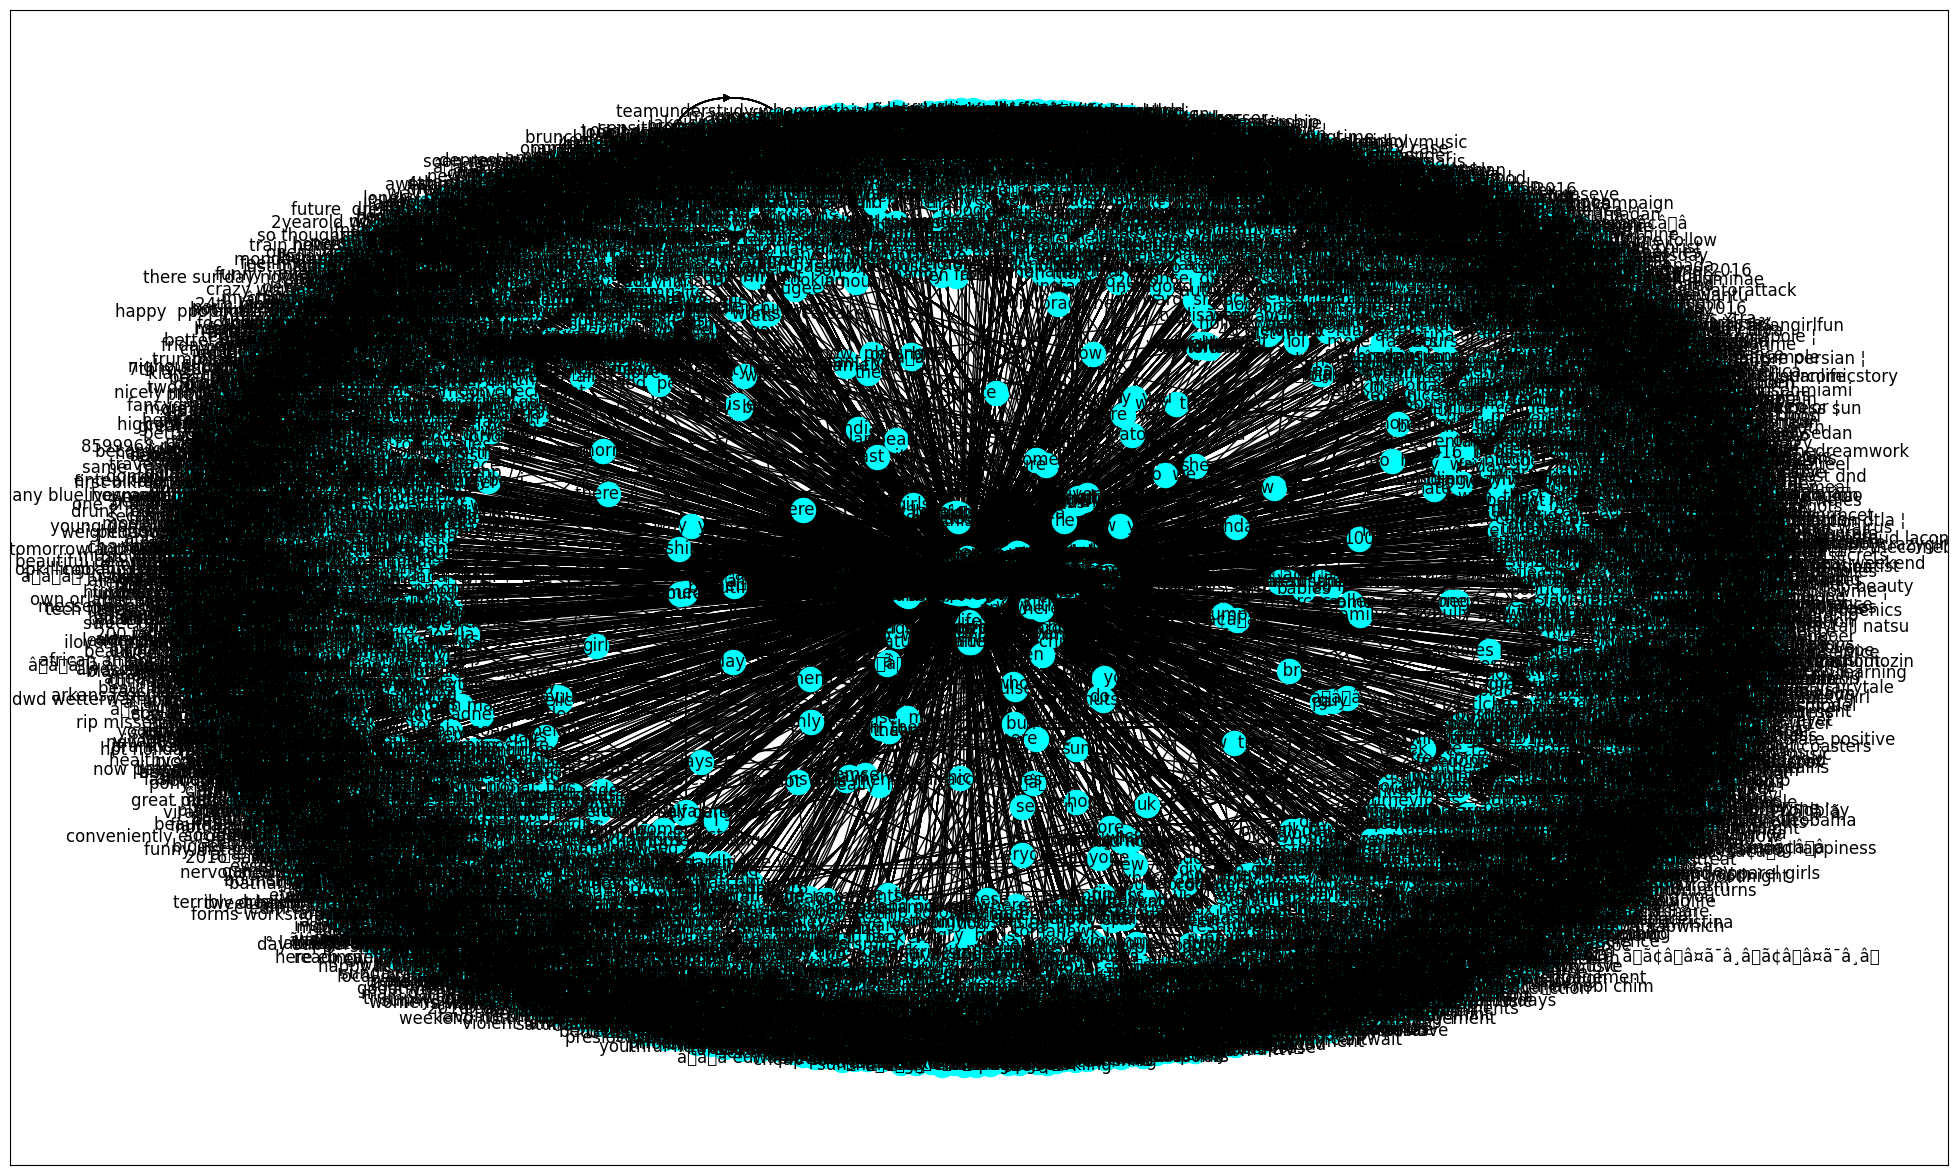

In [173]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(graph_df, "subject", "object",
                          edge_attr=True, create_using=nx.MultiDiGraph())
#Lets plot it using plotly
plt.figure(figsize=(25, 15))

pos = nx.spring_layout(G)
nx.draw_networkx(G, with_labels=True, node_color='Cyan', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Subject
Performing some graph analytics and what people are reffering to as "love" in the dataset

### Subject: 'I'

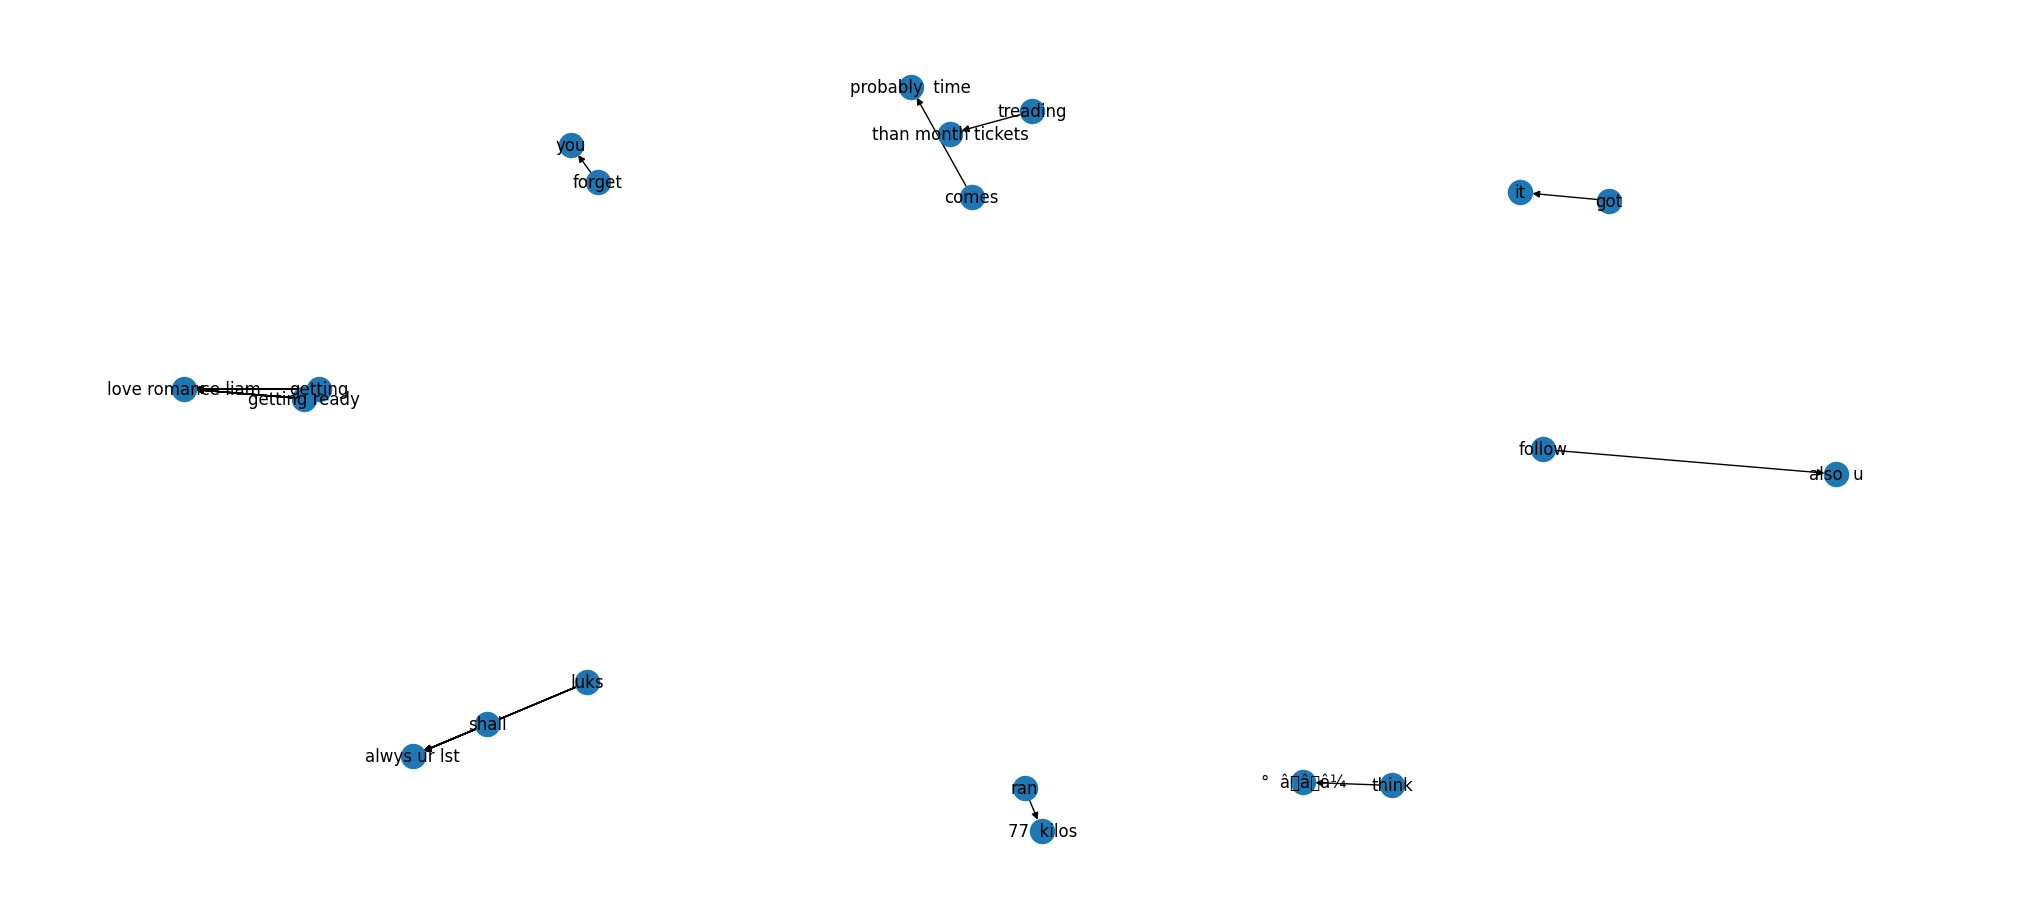

In [182]:
plt.figure(figsize=(20, 9))
G = nx.from_pandas_edgelist(graph_df[graph_df['subject'] == 'I'], "predicate", "object", edge_attr=True, create_using=nx.MultiDiGraph())
nx.draw(G, with_labels=True)
plt.show()

### Subject 'You'

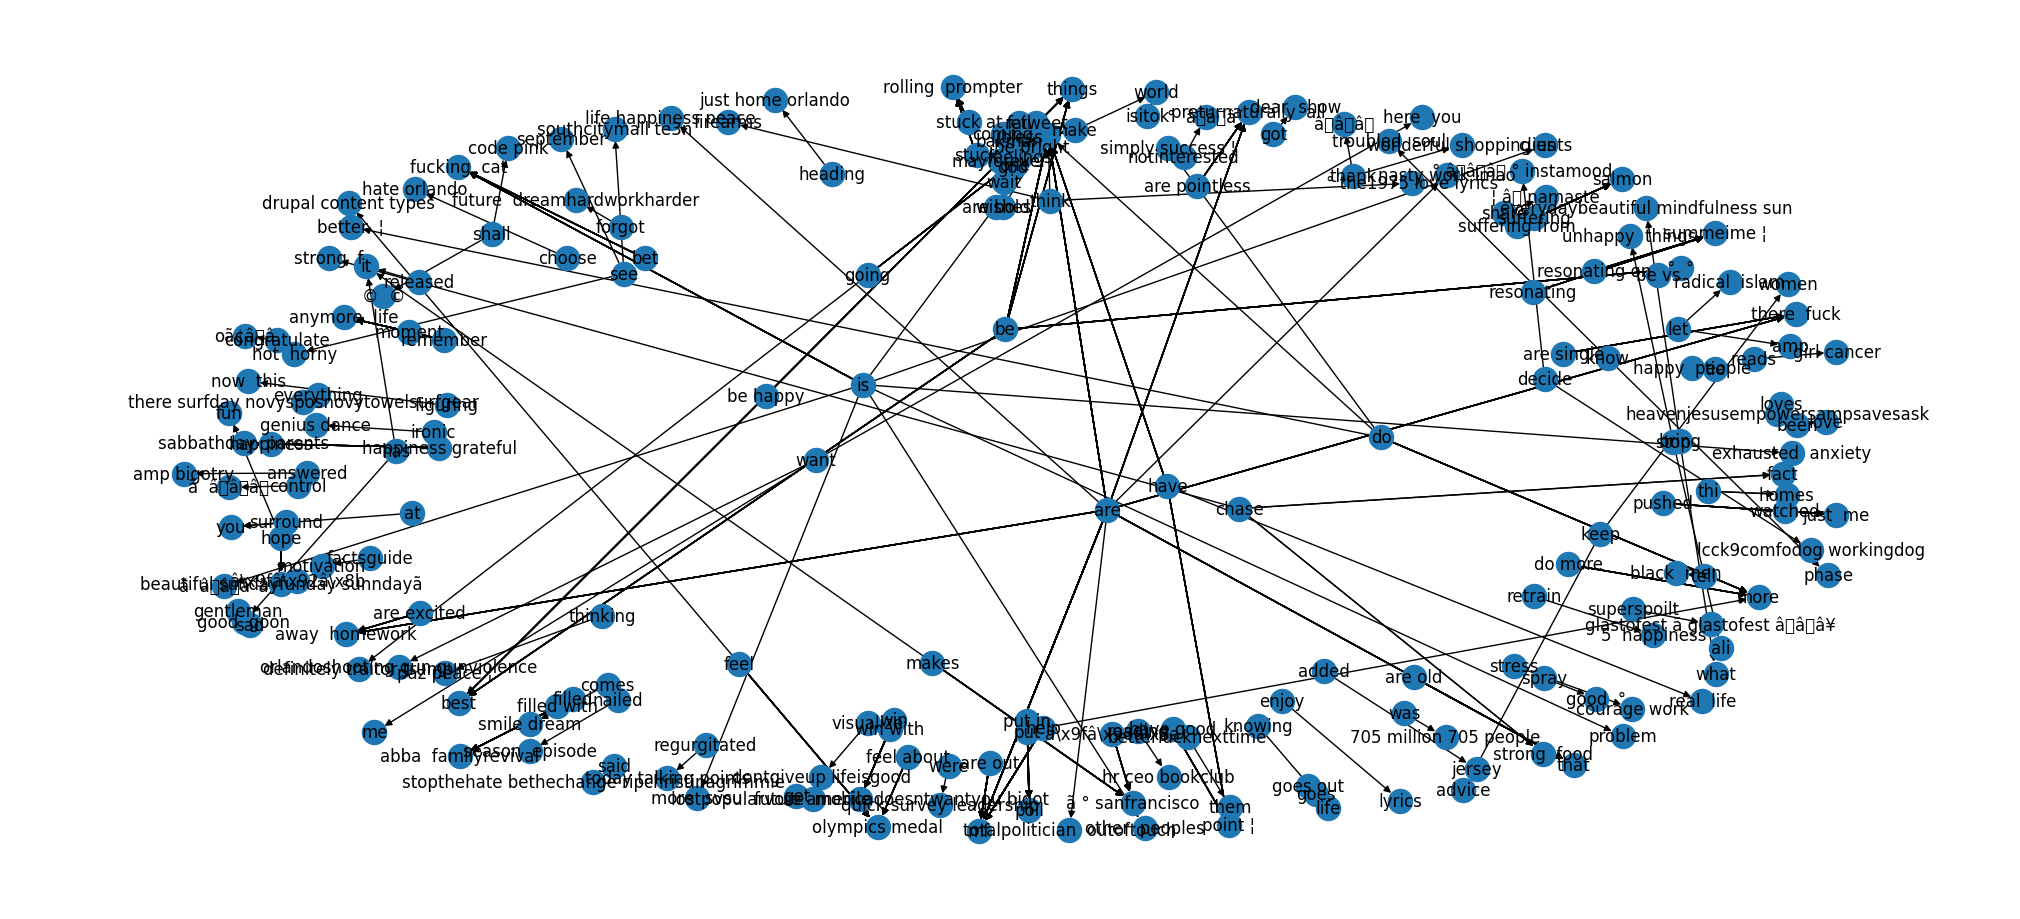

In [181]:
plt.figure(figsize=(20, 9))
G = nx.from_pandas_edgelist(graph_df[graph_df['subject'] == 'you'], "predicate", "object", edge_attr=True, create_using=nx.MultiDiGraph())
nx.draw(G, with_labels=True)
plt.show()

## Predicates
Performing some graph analytics and what people are reffering to as "love" in the dataset

### Love
Performing some graph analytics and what people are reffering to as "love" in the dataset

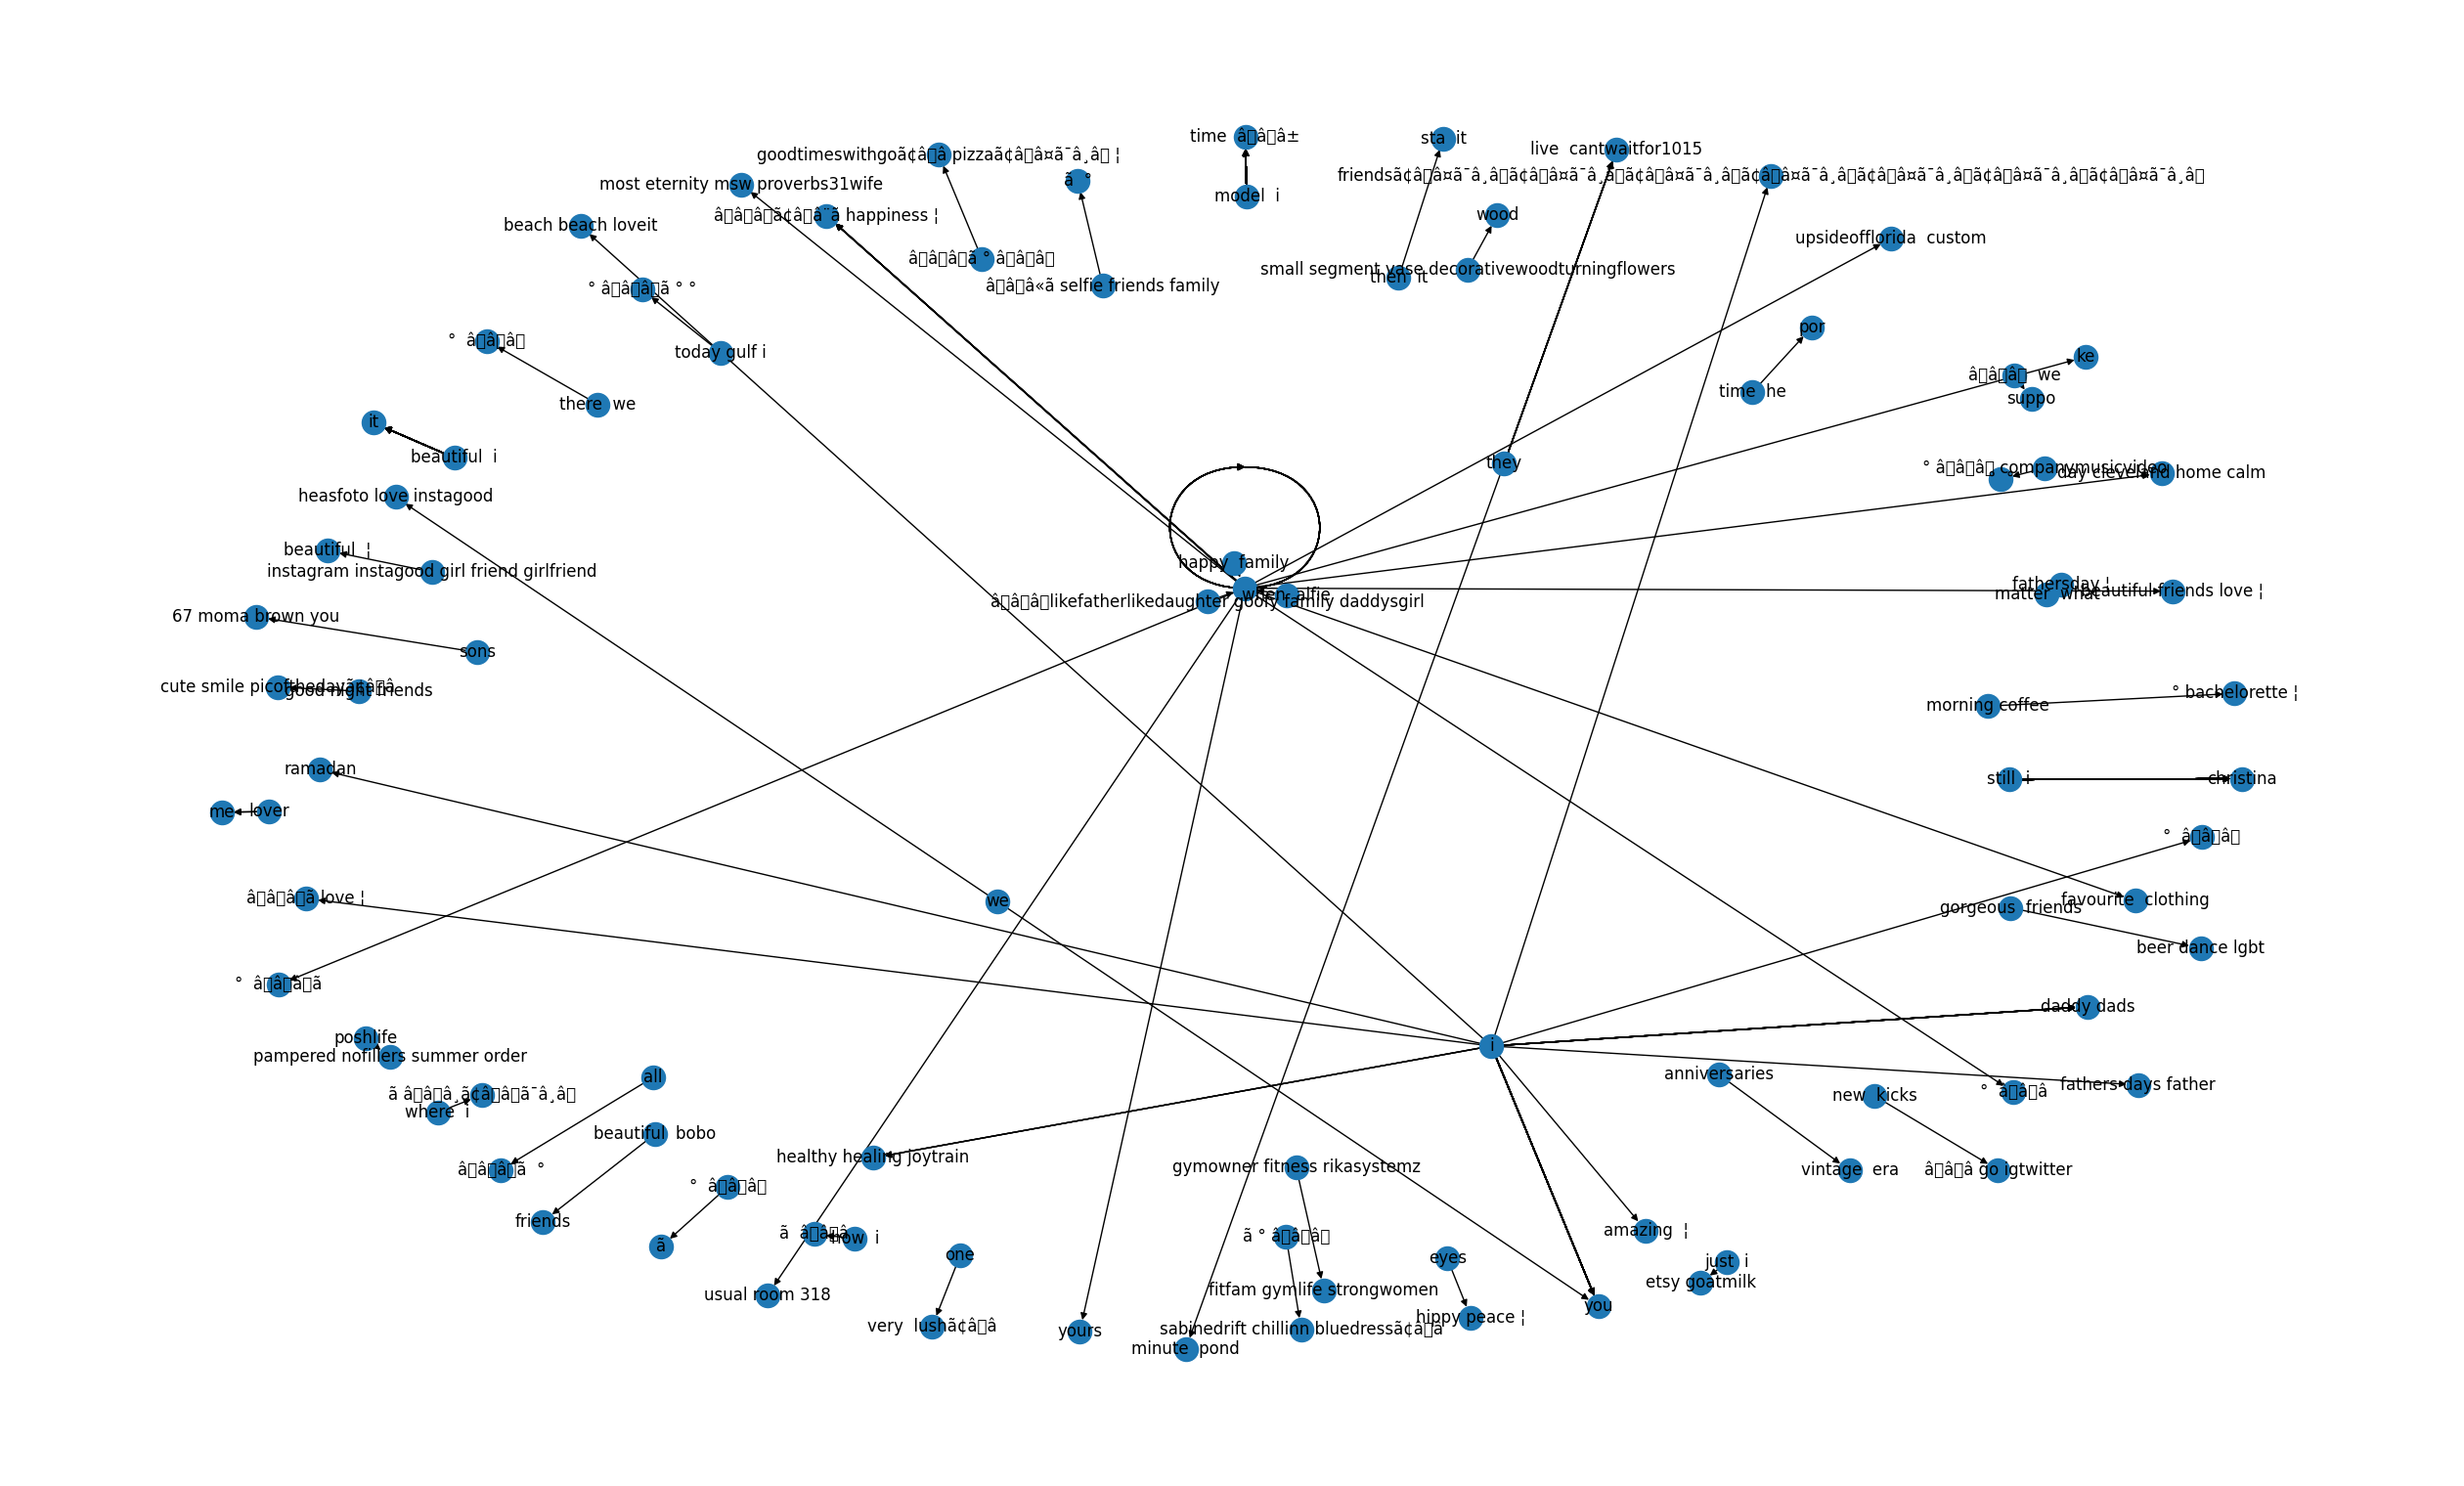

In [174]:
plt.figure(figsize=(25, 15))
G = nx.from_pandas_edgelist(graph_df[graph_df['predicate'] == 'love'], "subject", "object", edge_attr=True, create_using=nx.MultiDiGraph())
nx.draw(G, with_labels=True)
plt.show()


### Hate

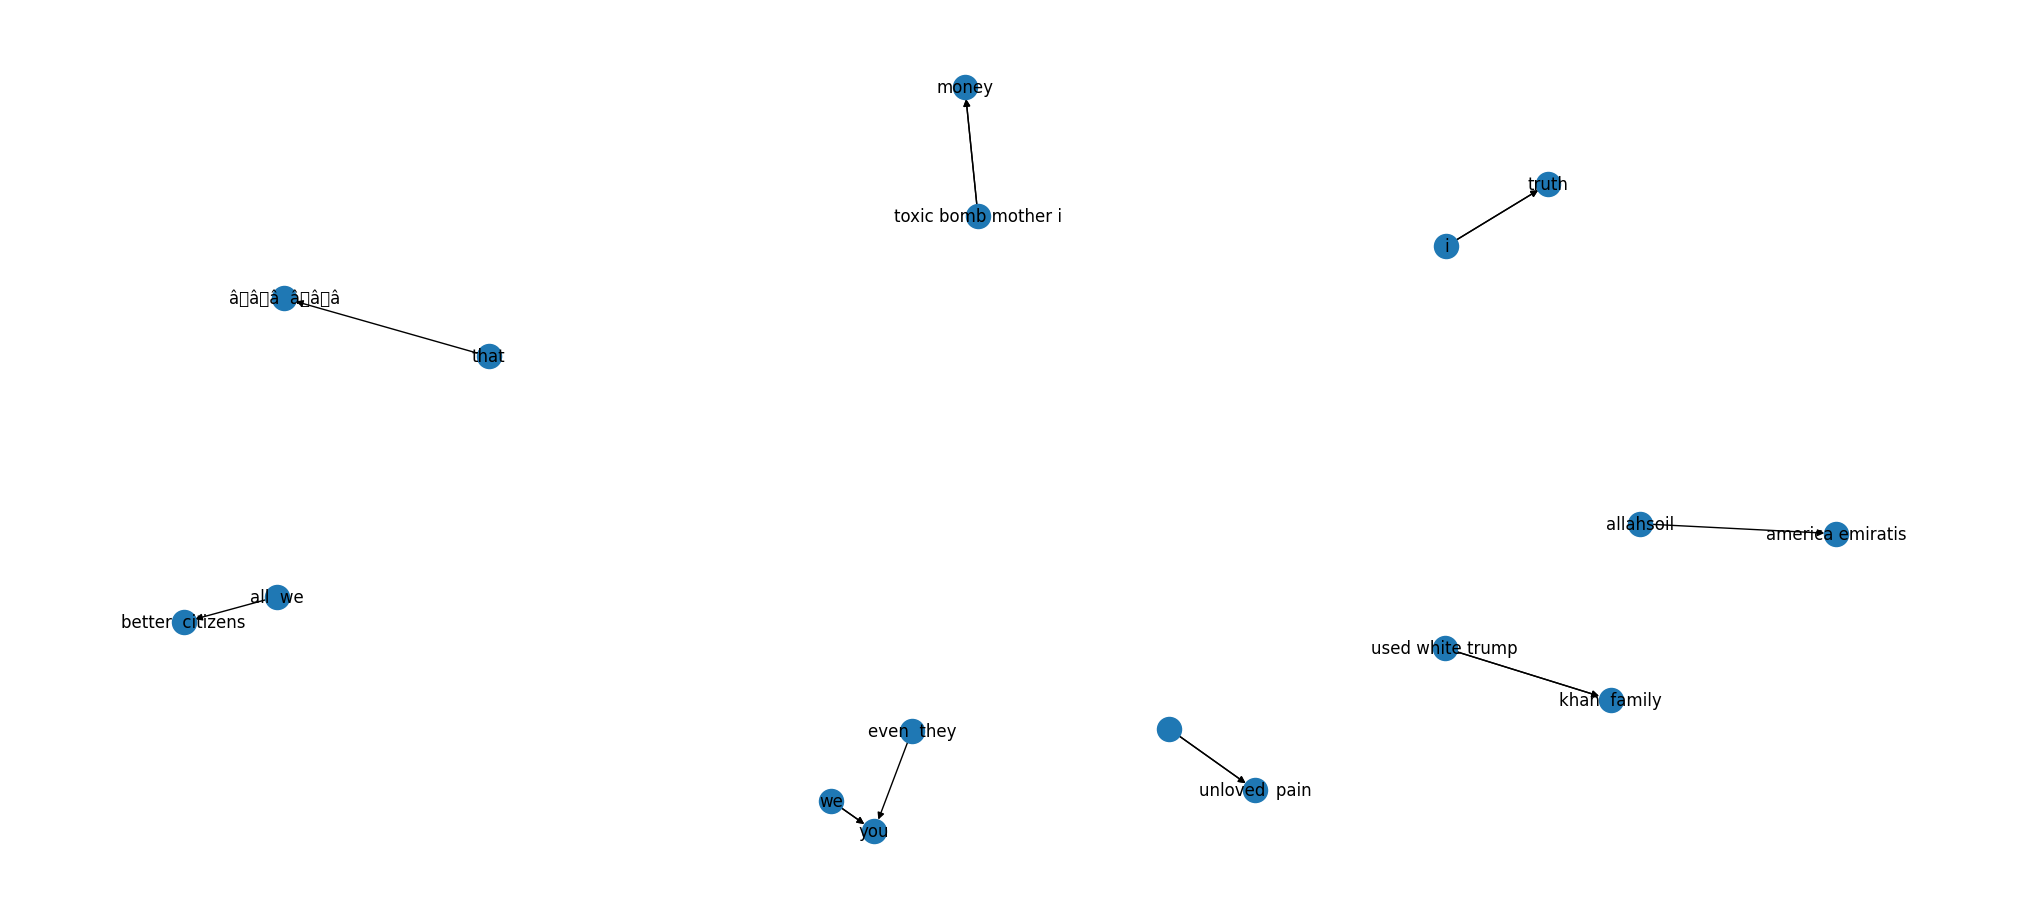

In [114]:
G = nx.from_pandas_edgelist(graph_df[graph_df['predicate'] == 'hate'], "subject", "object", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20, 9))
nx.draw(G, with_labels=True)

In [ ]:
G = nx.from_pandas_edgelist(graph_df[graph_df['predicate'] == 'happy'], "subject", "object", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20, 9))
nx.draw(G, with_labels=True)

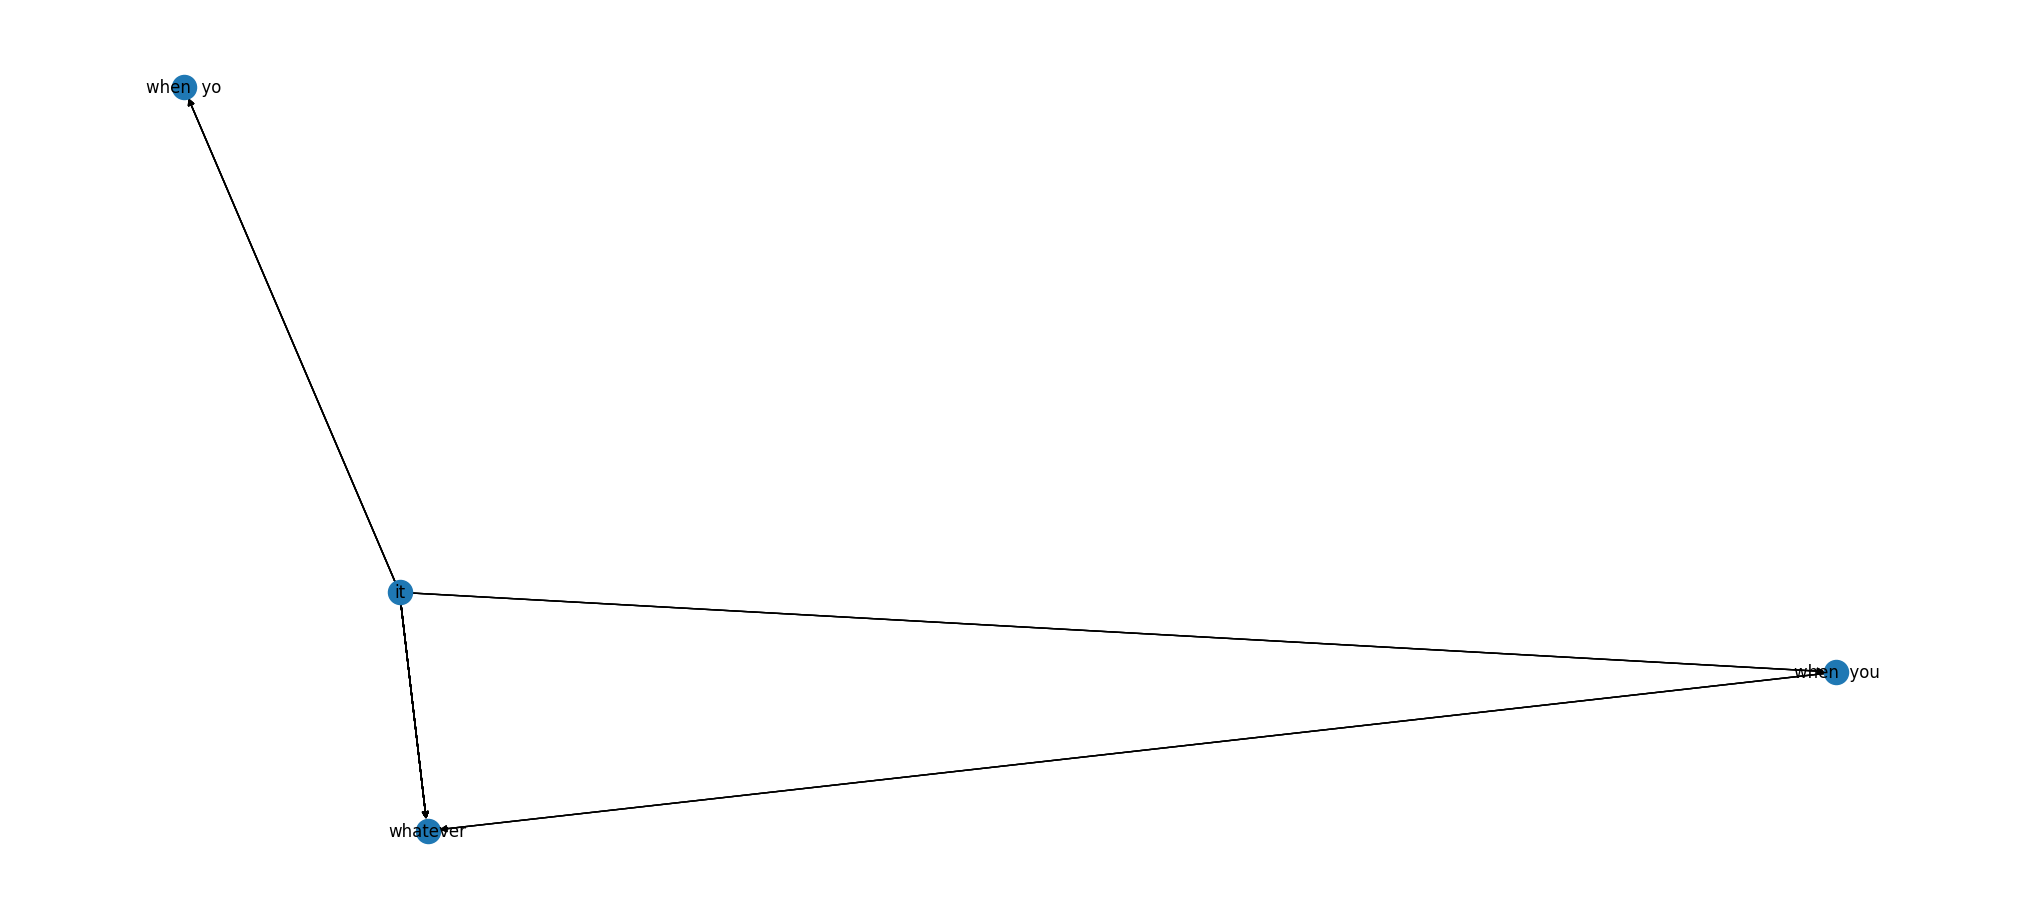

In [126]:
G = nx.from_pandas_edgelist(graph_df[graph_df['predicate'] == 'dominate'], "subject", "object", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20, 9))
nx.draw(G, with_labels=True)

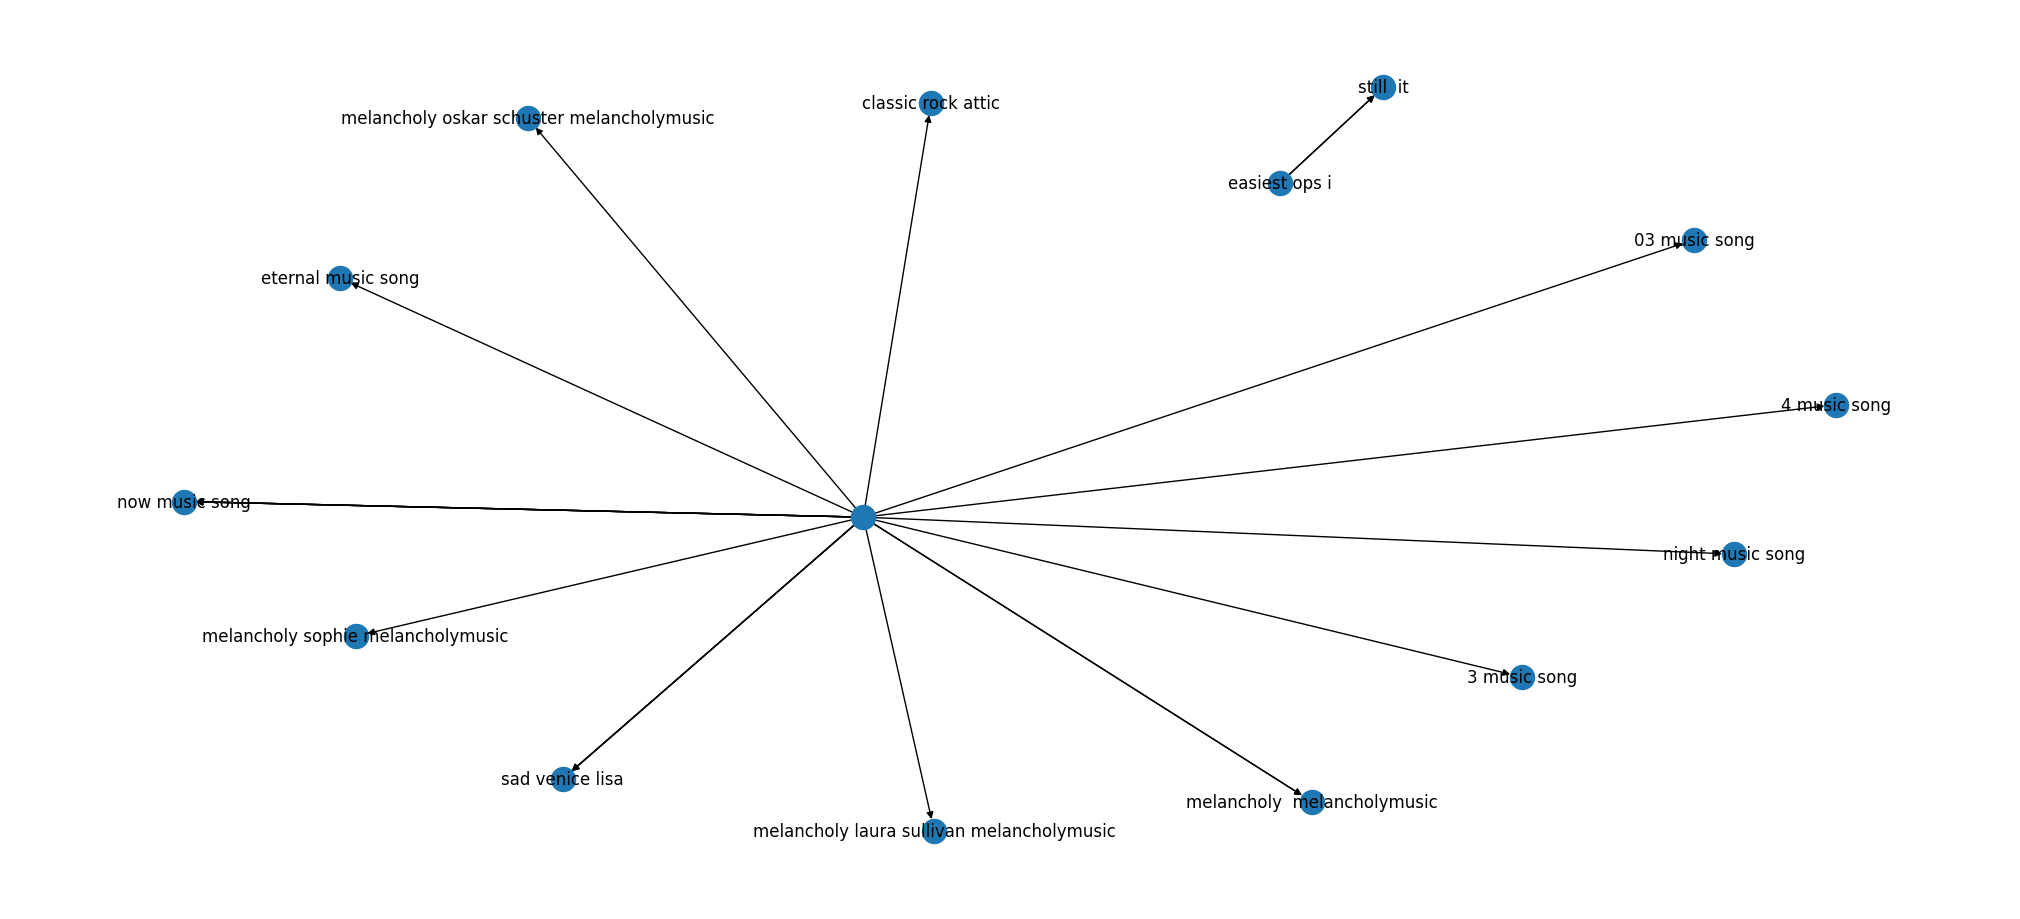

In [121]:
G = nx.from_pandas_edgelist(graph_df[graph_df['predicate'] == 'playing'], "subject", "object", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20, 9))
nx.draw(G, with_labels=True)

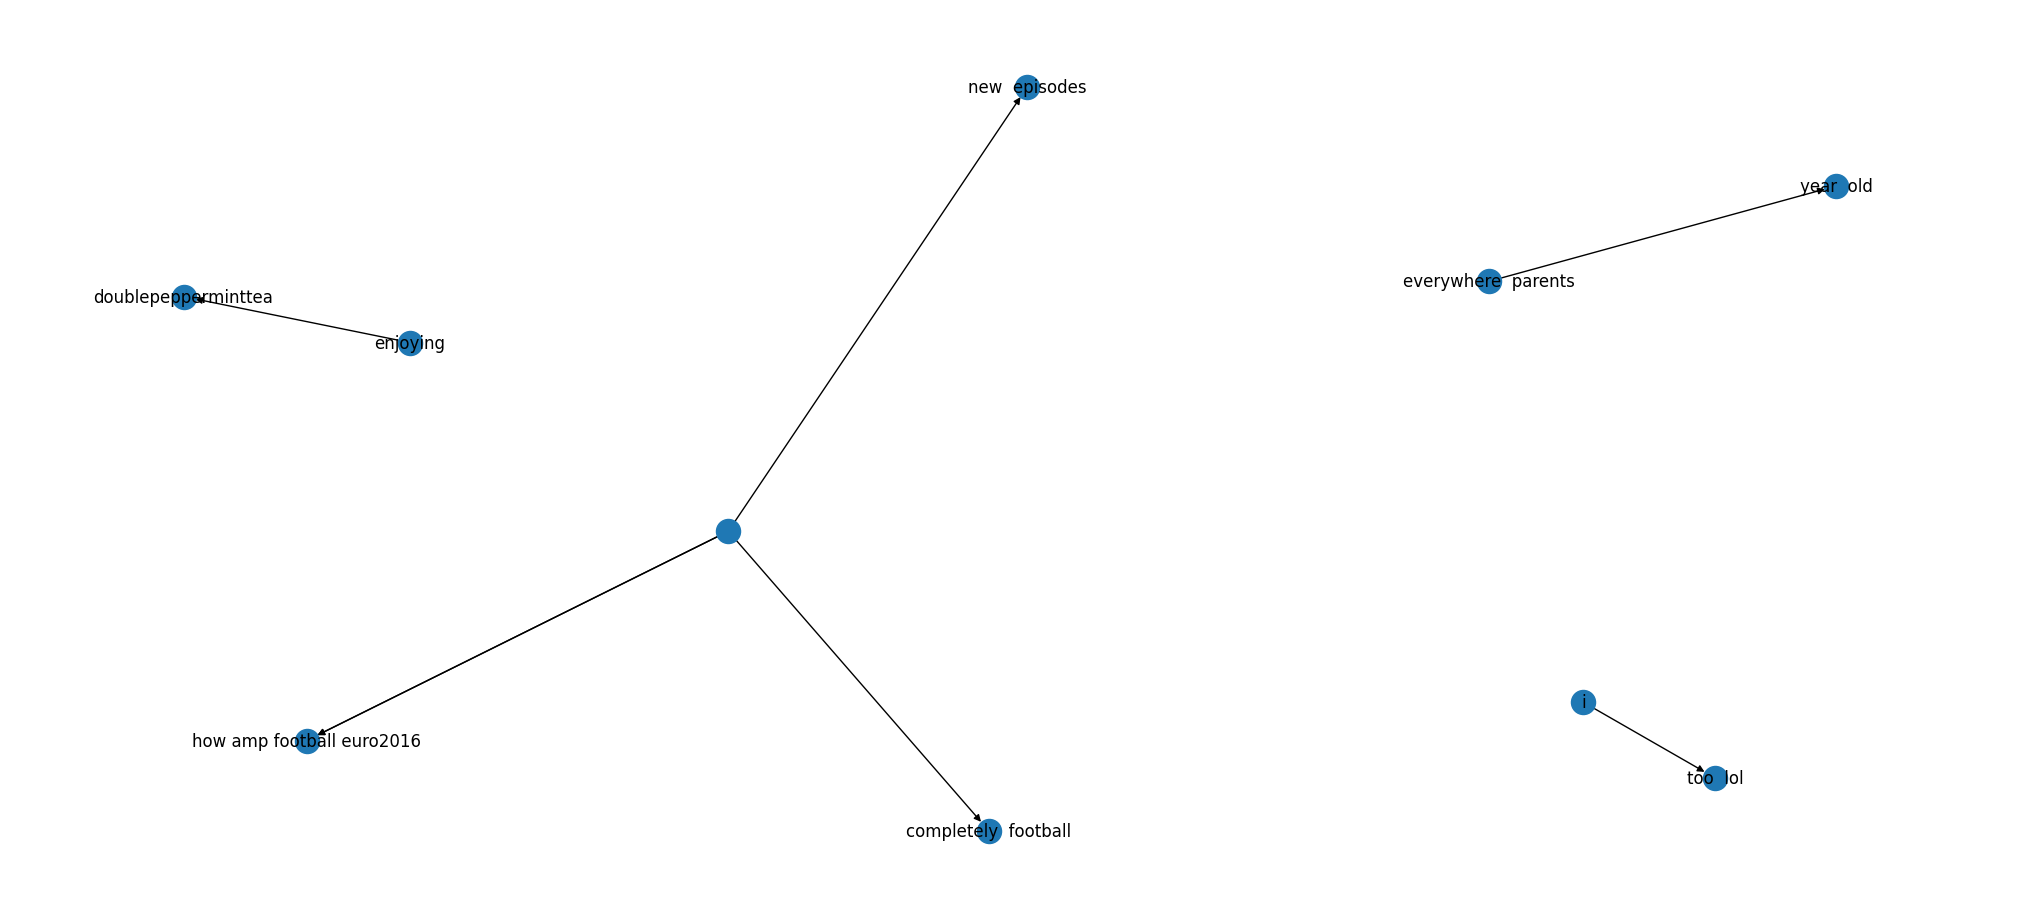

In [122]:
G = nx.from_pandas_edgelist(graph_df[graph_df['predicate'] == 'watching'], "subject", "object", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20, 9))
nx.draw(G, with_labels=True)

# Conclusion:
This analyis was an example of solution to businesses dealing with large volumes of text data. By employing NLP techniques and graph visualization, it enables businesses to extract valuable insights, understand relationships, and make data-driven decisions. Whether it is analyzing customer feedback, social media interactions, or any other text-based data source, this should provides a robust framework to gain a deeper understanding of the data and leverage it to improve business outcomes.